In [1]:
## for data
import pandas as pd
# import collections
import json
from sklearn.model_selection import train_test_split
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import scattertext as st
## for text processing
import re
import nltk

## რა იცი რაში დაგჭირდეს
import numpy as np

In [3]:
import fasttext

In [4]:
data = pd.read_csv("jobs_data\engineering_jobs.csv")

In [5]:
cols = ["skills","Unnamed: 0"]
data = data.drop(cols, axis=1)

In [6]:
data = data.dropna(thresh=2)

In [7]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(text).lower().strip())
    
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [8]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [9]:
manual_stop_words = []
with open('stop_words_english.txt', 'r', encoding='utf8') as words:
      for line in words:
            manual_stop_words.append(line.rstrip())

In [10]:
data["description_clean"] = data["description"].apply(lambda x: utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=manual_stop_words))

In [11]:
data["title_clean"] = data["title"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=False, lst_stopwords=manual_stop_words))

In [12]:
unique_categories = data.title_clean.unique()
dict_map = dict(zip(unique_categories, range(len(unique_categories))))
data["title_index"] = data.title_clean.map(dict_map)

In [103]:
data = data[data.duplicated(subset=['title_index'], keep=False)]

In [104]:
data.title_index.value_counts()

33       4146
49       3844
1        1091
2108      556
230       519
         ... 
7143        2
7128        2
7107        2
7086        2
66819       2
Name: title_index, Length: 10438, dtype: int64

In [112]:
X_train,X_test, y_train, y_test = train_test_split(data['description_clean'].values, data['title_index'].values, test_size=0.2, train_size=0.8, random_state=42, stratify=data['title_index'])

## FASTTEXT -  Create New Column: Give Each Category an Numerical Index

In [13]:
#make dictionary of the category mappings
dict_map_label = {v:'__label__' + str(k) for k,v in enumerate(unique_categories)}

In [14]:
data["title_index_label"] = data.title_clean.map(dict_map_label)

In [15]:
title_desc = data['title_index_label'] + " " + data['description_clean']

In [16]:
## check if description start with __label__
res = []
for line in title_desc:
    res.append(line[:9])
set(res)

{'__label__'}

In [115]:
train = list(map(lambda x: '__label__' + str(x) + " ", y_train)) + X_train
test =  list(map(lambda x: '__label__' + str(x) + " ", y_test)) + X_test

## FASTTEXT - Train/Test 

In [17]:
train, test = train_test_split(title_desc, test_size=0.3, train_size=0.7, random_state=42)

In [18]:
#write test and train into files
with open("train.txt", "a") as file:
    for line in np.array(train):
        file.write(line + "\n")
with open("test.txt", "a") as file:
    for line in np.array(test):
        file.write(line + "\n")

In [ ]:
model = fasttext.train_supervised(input="train.txt", wordNgrams=1)

In [ ]:
#test
model.test("test.txt") #(n, precision, recall)

In [ ]:
model.predict('Experienced Data Scientist with a demonstrated history of working in the information technology and services industry. Skilled in Python (Programming Language), SQL and Data Science. Strong engineering professional graduated from Tbilisi State University.')

In [ ]:
dict_map

## DETAILED INFORMATION ABOUT THE DATASET

In [48]:
data.describe()

,title,description,basic_qualifications,prefered_qualifications,category,text_clean,title_clean
count,49281,49279,3305,3305,43893,49281,49281
unique,21402,49279,3032,2993,689,49000,20601
top,data scientist,You are an experienced hands-on manager with a...,Position Requirements:Master's degree or forei...,Applicants must meet all of the above listed r...,Trades & Services,decade proforce helped 15000 graduates step co...,data scientist
freq,4016,1,5,33,3120,4,4128


In [49]:
data.title.value_counts(), data.title.value_counts(normalize=True)

(data scientist                                   4016
 software developer                               3585
 software development engineer                    1077
 junior software developer                         335
 project manager                                   251
                                                  ... 
 data scientist : 19-01679                           1
 insurance claims consultants                        1
 data scientist, ad platforms                        1
 head of talent                                      1
 refrigeration and air-conditioning apprentice       1
 Name: title, Length: 21402, dtype: int64,
 data scientist                                   0.081492
 software developer                               0.072746
 software development engineer                    0.021854
 junior software developer                        0.006798
 project manager                                  0.005093
                                                    ...  

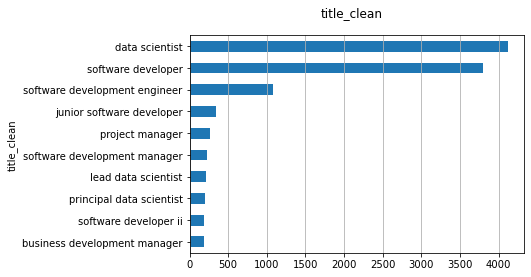

In [47]:
fig, ax = plt.subplots()
fig.suptitle('title_clean', fontsize=12)
data['title_clean'].reset_index().groupby('title_clean').count().sort_values(by= 
       "index").tail(10).plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Title', fontsize=12)
for i in data[y].unique():
    sns.distplot(data[data[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(dtf[y].unique())
ax[1].grid(True)
plt.show()

## Indeed files

In [66]:
path_str = r"C:\Users\annch\OneDrive\Desktop\untitled folder\indeed_usa-indeed_usa_job_data__20211001_20211231_deduped_n_merged_20220305_004328202689288.ldjson"
path_str1 = r"C:\Users\annch\OneDrive\Desktop\untitled folder\indeed_usa-indeed_usa_job_data__20211001_20211231_deduped_n_merged_20220305_004258919873466.ldjson"

In [75]:
lst_dics = []
with open(path_str1, mode='r', errors='ignore', encoding="utf8") as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
## print the first one      
lst_dics[0]

{'uniq_id': '5e5c32d6ed35211e3f7a5842858fc5e9',
 'crawl_timestamp': '2021-12-24 15:12:25 +0000',
 'url': 'https://www.indeed.com/viewjob?jk=5b351498df632075',
 'job_title': 'Electrical Construction Project Manager',
 'category': 'Customer Service',
 'company_name': 'Adams Electric Company',
 'city': 'Durham',
 'state': 'NC',
 'country': 'US',
 'post_date': '2021-12-24',
 'job_description': 'Company Description - Adams Electric is committed to exceeding our clients expectations. We add value to our clients through our passionate team committed to achieving excellence and creating relationships built to last. We know our associates are our best asset. Therefore, we invest in our associates by providing skilled training programs and opportunities for professional growth. By creating a culture based on safety, teamwork and trust; our associates have the confidence, training and knowledge to build a successful and long-lasting career at Adams Electric. General Position Summary Adams Electri

In [76]:
dtf1 = pd.DataFrame(lst_dics)

In [68]:
dtf = pd.DataFrame(lst_dics)

In [90]:
both_dtf = pd.concat([dtf1[['job_title', 'job_description']],dtf[['job_title', 'job_description']]]).rename(columns = {'job_title':'title','job_description':'description'})

In [91]:
both_dtf

,title,description
0,Electrical Construction Project Manager,Company Description - Adams Electric is commit...
1,Laundry Attendant,Job Summary: Información disponible en español...
2,Professional Organizer,Our team is seeking an expert in the field of ...
3,Construction Estimator,"CDI Contractors, LLC is a progressive construc..."
4,Dishwasher,Are you looking for an opportunity and growth ...
...,...,...
49995,Biomedical Technician 1 Chicago IL,Job Description Summary As the Biomed Technici...
49996,Marketing Assistant,"Sports Facilities Management, LLC- Cornerstone..."
49997,Core Supervisor,We are looking for a Core Supervisor 40 hours ...
49998,Stores Supervisor,We are LAUSD. We are at the forefront of innov...


In [97]:
data = pd.concat([data[['title', 'description']],both_dtf])

In [99]:
data

,title,description
0,software development manager,You are an experienced hands-on manager with a...
1,software development engineer,Amazon is driven by being “the world’s most cu...
2,software development engineer,Have you ever wondered what it takes to build ...
3,quality assurance engineer,Fire TV client software and service technologi...
4,software development engineer,The Amazon Devices team designs and engineers ...
...,...,...
49995,Biomedical Technician 1 Chicago IL,Job Description Summary As the Biomed Technici...
49996,Marketing Assistant,"Sports Facilities Management, LLC- Cornerstone..."
49997,Core Supervisor,We are looking for a Core Supervisor 40 hours ...
49998,Stores Supervisor,We are LAUSD. We are at the forefront of innov...


 - Prepare Dataset
 - Split Dataset into 3 (train/test/dev)
 - Create a Corpus & Label Dictionary + Embeding
 - Build ML & Train & Save as pt
 - Load ML & Predict

In [135]:
import flair

In [179]:
flair.__version__

'0.11.3'

### Prepare Dataset

In [149]:
flair_data = pd.read_csv(r'C:\Users\annch\PycharmProjects\jobTitlePrediction\media\output\result.csv', index_col=[0])

In [150]:
unique_categories = flair_data.title_clean.unique()
dict_map = dict(zip(unique_categories, range(len(unique_categories))))
flair_data["title_index"] = flair_data.title_clean.map(dict_map)

In [155]:
# flair_data = flair_data[flair_data.duplicated(subset=['title_index'], keep=False)]

In [158]:
flair_data['title_clean'] = '__label__'+flair_data['title_clean']

In [160]:
flair_data = flair_data[['description_clean','title_clean']]

### Split Dataset into 3 (train/test/dev) and save

In [162]:
train_fst, test_fst, dev_fst = np.split(flair_data, [int(.6*len(flair_data)), int(.8*len(flair_data))])

In [164]:
train_fst.to_csv('data_fst/train.csv', sep='\t', index=False, header=False)
test_fst.to_csv('data_fst/test.csv', sep='\t', index=False, header=False)
dev_fst.to_csv('data_fst/dev.csv', sep='\t', index=False, header=False)

In [169]:
!dir data_fst

 Volume in drive C has no label.
 Volume Serial Number is 60AB-5A5B

 Directory of C:\Users\annch\data_fst

08/07/2022  02:23 AM    <DIR>          .
08/07/2022  02:23 AM    <DIR>          ..
08/07/2022  02:23 AM        79,721,130 dev.csv
08/07/2022  02:23 AM        78,177,515 test.csv
08/07/2022  02:23 AM       203,845,796 train.csv
               3 File(s)    361,744,441 bytes
               2 Dir(s)  129,908,961,280 bytes free


### Create a Corpus & Label Dictionary + Embeding
Building our Corpus<br>
CSVClassificationCorpus<br>
ClassificationCorpus<br>

In [172]:
flair_data

,description_clean,title_clean
0,experienced handson manager background develop...,__label__software development manager
1,amazon driven worlds customer centric company ...,__label__software development engineer
2,wondered takes build intelligence enterprise s...,__label__software development engineer
3,tv client software service technologies enjoye...,__label__quality assurance engineer
4,amazon devices team designs engineers highprof...,__label__software development engineer
...,...,...
49995,job description summary biomed technician resp...,__label__biomedical technician 1 chicago il
49996,sports facilities management llc cornerstone p...,__label__marketing assistant
49997,core supervisor 40 hours week peoria il locati...,__label__core supervisor
49998,lausd forefront innovation public schools work...,__label__stores supervisor


In [171]:
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus
from flair.data import Corpus

In [173]:
column_name_map = {2:'title_clean', 1: "description_clean"}

In [178]:
# Create Corpus for CSV
data_folder = 'data_fst/'
corpus_csv: Corpus = CSVClassificationCorpus(data_folder=data_folder, label_type='title_clean', column_name_map=column_name_map, skip_header=True, delimiter=',')
    

2022-08-07 02:34:59,301 Reading data from data_fst
2022-08-07 02:34:59,309 Train: data_fst\train.csv
2022-08-07 02:34:59,309 Dev: data_fst\dev.csv
2022-08-07 02:34:59,309 Test: data_fst\test.csv


RuntimeError: No data provided when initializing corpus object.

In [177]:
corpus_csv

NameError: name 'corpus_csv' is not defined